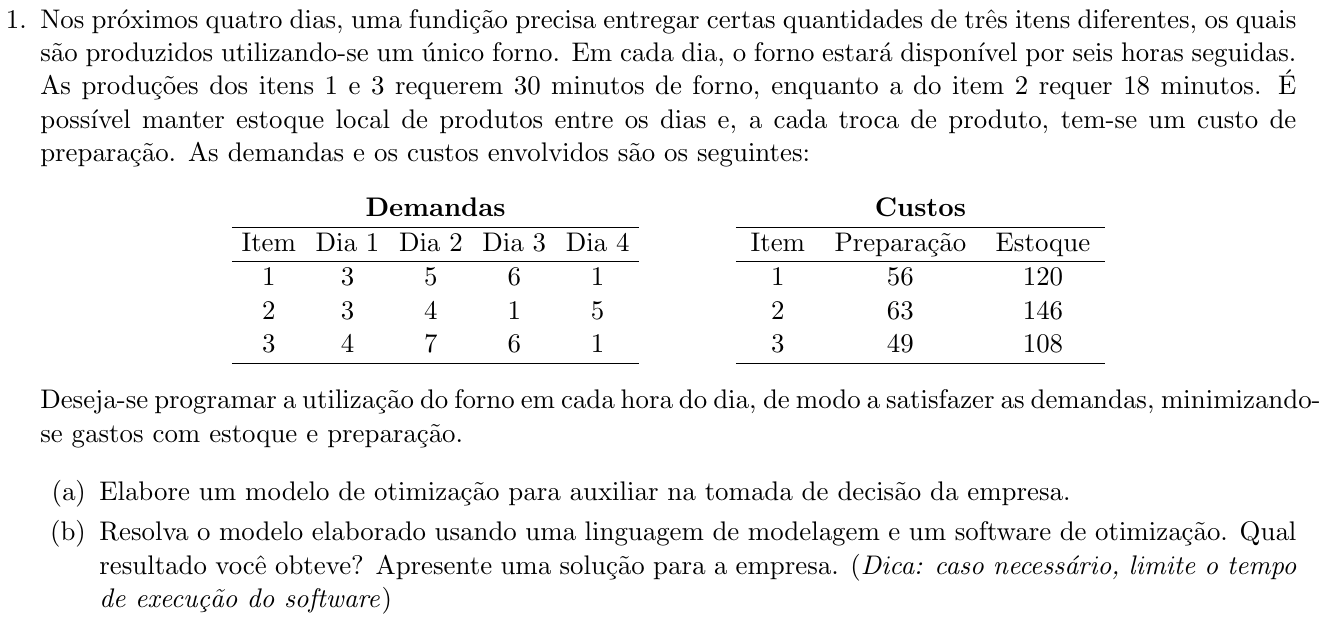

In [8]:
from IPython.display import Image
Image(filename='images/1.png')

In [3]:
# Módulos
from pyomo.environ import *
from pyomo.opt import SolverFactory

In [4]:
# Dados
# Conjuntos
Produtos = [1, 2, 3]
Macroperiodos = [0, 1, 2, 3, 4]
Microperiodos = [i for i in range(0, 25)]
# Params
micro_inicial = {0: 0, 1: 1, 2: 7, 3: 13, 4: 19}
micro_final = {0: 0, 1: 6, 2: 12, 3: 18, 4: 24}
tempo_prod = {1: 0.5, 2: 0.3, 3: 0.5}
custo_prep = {1: 56, 2: 63, 3: 49}
custo_estoque = {1: 120, 2: 146, 3: 108}
demandas = {(1,0): 0, (1,1): 3, (1,2): 5, (1,3): 6,(1,4): 1, 
            (2,0): 0, (2,1): 3, (2,2): 4, (2,3): 1, (2,4): 5,
            (3,0): 0, (3,1): 4, (3,2): 7, (3,3): 6, (3,4): 1}
tempo_disponivel = {0: 0, 1: 6, 2: 6, 3: 6, 4: 6}

M = 10**6
# print(small)

In [5]:
# Modelo
model = ConcreteModel()

# Conjuntos
model.P = Set(initialize=Produtos)
model.T = Set(initialize=Macroperiodos)
model.S = Set(initialize=Microperiodos)
P, T, S = model.P, model.T, model.S

# Parâmetros
model.F = Param(T, initialize=micro_inicial, within=NonNegativeReals)
model.L = Param(T, initialize=micro_final, within=NonNegativeReals)
model.d = Param(P * T, initialize=demandas, within=NonNegativeReals)
model.a = Param(P, initialize=tempo_prod, within=NonNegativeReals)
model.C = Param(T, initialize=tempo_disponivel, within=NonNegativeReals)
model.h = Param(P, initialize=custo_estoque, within=NonNegativeReals)
model.u = Param(P, initialize=custo_prep, within=NonNegativeReals)
F, L, d, a, C, h, u = model.F, model.L, model.d, model.a, model.C, model.h, model.u

# Variáveis de decisão
model.x = Var(P * S, within=NonNegativeIntegers)
model.I = Var(P * T, within=NonNegativeIntegers)
model.y = Var(P * S, within=Binary)
model.z = Var(P * S, within=Binary)
x, I, y, z = model.x, model.I, model.y, model.z

# Função objetivo
model.obj = Objective(sense=minimize, 
                      expr = (sum(sum(h[i] * I[i, t] for i in P) for t in T))
                      + sum(sum(u[i] * y[i, s] for i in P) for s in S))

# Restrições
# Conservação de estoque
model.r_conservacao = ConstraintList()
for i in P:
  model.r_conservacao.add(expr = I[i, 0] == 0)
  for t in T:
    if t > 0:
      model.r_conservacao.add(expr = I[i, t-1] + sum(x[i, s] for s in range(F[t], L[t] + 1)) - I[i, t] - d[i, t] == 0)
# Capacidade de tempo do macroperíodo
model.r_capacidade = ConstraintList()
for t in T:
  model.r_capacidade.add(expr = sum(sum(a[i] * x[i, s] for s in range(F[t], L[t] + 1)) for i in P) <= C[t])
# 1 produto por microperíodo
model.r_micro = ConstraintList()
for s in S:
  model.r_micro.add(expr = sum(z[i, s] for i in P) <= 1)
# Produção no microperíodo
model.r_prod_micro = ConstraintList()
for i in P:
  for t in T:
    for s in range(F[t], L[t] + 1):
      model.r_prod_micro.add(expr = a[i] * x[i, s] <= C[t] * z[i, s])
# Preparação no microperíodo
model.r_prep_micro = ConstraintList()
for i in P:
  model.r_prep_micro.add(expr = z[i, 0] == 0)
  for s in S:
    if s > 0:
      model.r_prep_micro.add(expr = y[i, s] >= z[i, s] - z[i, s-1])

# model.pprint()

In [6]:
# Resolução
solver = SolverFactory('glpk')
resultado = solver.solve(model, tee=False, timelimit=30)

In [7]:
# Apresentação de resultados
if (resultado.solver.status == SolverStatus.ok) and (resultado.solver.termination_condition != TerminationCondition.infeasible):
    for i in P:
      for s in S:
        if value(x[i, s]) > 0:
          print('Serão produzidas {} unidades do produto {} na hora {}'.format(value(x[i, s]), i, s))
    print()
    for i in P:
      for t in T:
        if value(I[i, t]) > 0:
          print('Serão estocadas {} unidades do produto {} no dia {}'.format(value(I[i, t]), i, t))
    print()
    print('O custo mínimo é de ${:.2f}'.format(value(model.obj)))
else:
    print(resultado.solver.termination_condition)

Serão produzidas 3.0 unidades do produto 1 na hora 1
Serão produzidas 3.0 unidades do produto 1 na hora 11
Serão produzidas 2.0 unidades do produto 1 na hora 12
Serão produzidas 6.0 unidades do produto 1 na hora 13
Serão produzidas 1.0 unidades do produto 1 na hora 24
Serão produzidas 2.0 unidades do produto 2 na hora 3
Serão produzidas 1.0 unidades do produto 2 na hora 6
Serão produzidas 5.0 unidades do produto 2 na hora 7
Serão produzidas 5.0 unidades do produto 2 na hora 22
Serão produzidas 7.0 unidades do produto 3 na hora 2
Serão produzidas 4.0 unidades do produto 3 na hora 10
Serão produzidas 6.0 unidades do produto 3 na hora 18
Serão produzidas 1.0 unidades do produto 3 na hora 19

Serão estocadas 1.0 unidades do produto 2 no dia 2
Serão estocadas 3.0 unidades do produto 3 no dia 1

O custo mínimo é de $911.00
